# CycleGAN | Photo to Monet
This notebook uses the CycleGAN generative adversarial network to stylize photos in the style of Monet as described in paper [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/pdf/1703.10593).

Image-to-image translation tasks are easy for humans. Humans  have no trouble imagining the scene that Monet painted as a true landscape, or vice versa. However, for machines this task is more challenging. Often there are no labeled examples for which to train a model (for example, a photograph and the resulting landscape painting). CycleGAN proposes an adversarial network that trains a generator to fool a discriminator that is trying to detect generated images. Over time, the generator learns the appropriate style to achieve the image-to-image translation task.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import PIL
import shutil
from tqdm import tqdm
import numpy as np

AUTOTUNE = tf.data.AUTOTUNE

print(tf.__version__)

2025-04-17 19:09:15.451198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744916955.672067      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744916955.731476      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.18.0


In [2]:
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print("✅ TPU initialized")
except ValueError:
    strategy = tf.distribute.get_strategy()  # Default to CPU/GPU
    print("❌ TPU not found, using default strategy")

❌ TPU not found, using default strategy


## Exploratory Data Analysis
The dataset contains four directories: `monet_tfrec`, `photo_tfrec`, `monet_jpg`, and `photo_jpg`, offering the same data in two formats: TFRecords and JPEG. For processing efficiency, I'll use the TFRecord files. The directories include
- monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
- photo_tfrec - 7028 photos sized 256x256 in TFRecord format

In [3]:
monet_tf_path = '/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec'
photo_tf_path = '/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec'

monet_tf = tf.data.Dataset.list_files(monet_tf_path)
photo_tf = tf.data.Dataset.list_files(photo_tf_path)

print('Monet TFRecord Files: ', len(monet_tf))
print('Photo TFRecord Files: ', len(photo_tf))

I0000 00:00:1744916970.148543      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Monet TFRecord Files:  5
Photo TFRecord Files:  20


## Data Preparation
Following the [TensorFlow CycleGAN tutorial](https://www.tensorflow.org/tutorials/generative/cyclegan) and [CycleGAN paper](https://arxiv.org/abs/1703.10593) referenced therein, I'll load the datasets from TFRecords. For training data, I'll apply the tranformations to avoid overfitting including
- random jittering - image is resized to 286 x 286 and then randomly cropped to 256 x 256.
- random mirroring - image is randomly flipped horizontally i.e., left to right.

The data preparation code will be organized in my `ImagePreprocessor` class.

In [4]:
IMAGE_SIZE = [256, 256]

class ImagePreprocessor:
    def __init__(self, training=True):
        self.training = training

    def decode(self, image):
        img = tf.image.decode_jpeg(image, channels=3)
        return img

    def read_tfrecord(self, tfrecord):
        format_tf = {
            'image_name': tf.io.FixedLenFeature([], tf.string),
            'image': tf.io.FixedLenFeature([], tf.string),
            'target': tf.io.FixedLenFeature([], tf.string),
        }
        ex = tf.io.parse_single_example(tfrecord, format_tf)
        image = self.decode(ex['image'])
        return image

    def random_crop(self, image):
        return tf.image.random_crop(image, size=[IMAGE_SIZE[0], IMAGE_SIZE[1], 3])

    def normalize(self, image):
        image = tf.cast(image, tf.float32)
        return (image / 127.5) - 1

    def random_jitter(self, image):
        image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        image = self.random_crop(image)
        image = tf.image.random_flip_left_right(image)
        return image

    def preprocess_image_train(self, image):
        image = self.random_jitter(image)
        return self.normalize(image)

    def preprocess_image_test(self, image):
        return self.normalize(image)

    def preprocess_image(self, tfrecord):
        image = self.read_tfrecord(tfrecord)
        if self.training:
            return self.preprocess_image_train(image)
        else:
            return self.preprocess_image_test(image)

    def load_dataset(self, tf_files, batch_size=1, repeat=True):
        dataset = tf.data.TFRecordDataset(tf_files)
        dataset = dataset.map(lambda x: self.preprocess_image(x), num_parallel_calls=AUTOTUNE)
        if repeat:
            dataset = dataset.repeat()
        dataset = dataset.shuffle(1024)
        dataset = dataset.batch(batch_size, drop_remainder=True)
        dataset = dataset.prefetch(AUTOTUNE)
        return dataset


In [5]:
train_preprocessor = ImagePreprocessor(training=True)
test_preprocessor = ImagePreprocessor(training=False)

monet_ds = train_preprocessor.load_dataset(monet_tf)
photo_ds = train_preprocessor.load_dataset(photo_tf)
test_monet_ds = test_preprocessor.load_dataset(monet_tf, repeat=False)
test_photo_ds = test_preprocessor.load_dataset(photo_tf, repeat=False)

In [6]:
print("Monet Images: ", sum(1 for _ in tf.data.TFRecordDataset(monet_tf)))
print('Photo Images: ', sum(1 for _ in tf.data.TFRecordDataset(photo_tf)))

Monet Images:  300
Photo Images:  7038


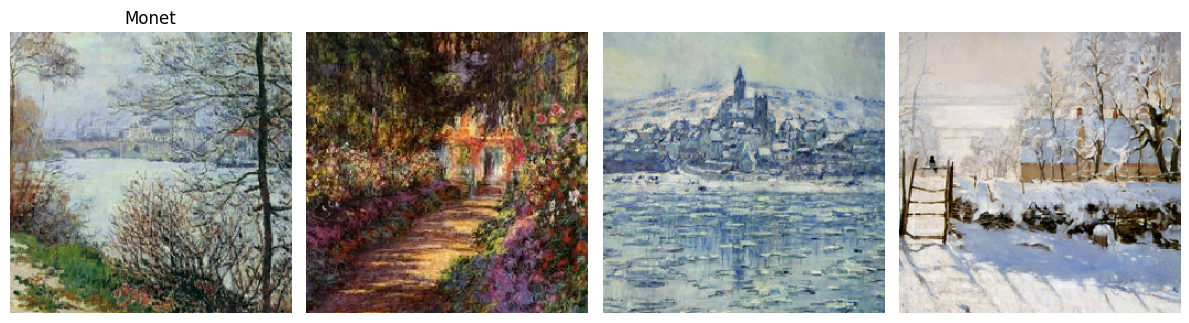

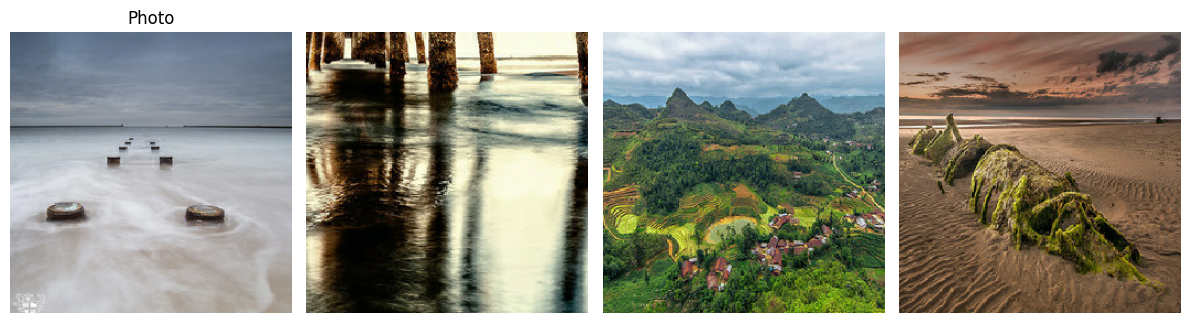

In [7]:
def show_img(ds, title):
    plt.figure(figsize=(12,6))
    for i, img in enumerate(ds.take(4)):
        plt.subplot(1, 4, i+1)
        plt.imshow(tf.squeeze(img, axis=0) * 0.5 + 0.5)
        plt.axis('off')
        plt.title(title) if i == 0 else ''
    plt.tight_layout()
    plt.show()

show_img(monet_ds, 'Monet')
show_img(photo_ds, 'Photo')

## Model Architecture (Analysis Plan)
CycleGAN is an adversarial approach to translating an image from one domain (e.g., a photo) to another domain (e.g., the painting style of Monet). As described in paper [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/pdf/1703.10593) the algorithm learns a mapping $G: X \to Y$ (i.e., from photos to Monet) with an inverse mapping $F: Y \to X$ (i.e., from Monet to photos) under the constraint $F(G(X)) \approx X$ such that cycling an image through will translate from one domain back to its own domain. This is akin to what humans do when imagining the actual landscape that Monet painted, or the way Monet might paint a landscape.

The algorithm is trained by training both the mapping G and F simultaneously, and adding a cycle consistency loss, where a descriminator learns to distinguish real from generated examples in each domain. The process is shown below

![img](https://www.tensorflow.org/static/tutorials/generative/images/cycle_loss.png)

The CycleGAN paper uses a modified resnet based generator. I instead implement a modified unet generator for simplicity. Inspiration for implementation provided by Amy Jang's implementation in the [CycleGAN Tutorial](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook) notebook.

### Generator
The generator first downsamples the image by striding across the image with stride=2 such that the width and height are reduced by half with each pass. Upsampling does the opposite. The idea is to create the stepped architecture such that the image is encoded to the latent space coding and then decoded in the new domain (learned through interaction with the discriminator). Instance normalization is applied for model stability and consistent style across imagesl dropout is applied for improved model generalization.  Skip connections bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one.

In [8]:
OUTPUT_CHANNELS = 3

class Generator:
        
    def downsample(self, filters, size, apply_instancenorm=True):
        initializer = tf.random_normal_initializer(0., 0.02)
        result = keras.Sequential()
        result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                                 kernel_initializer=initializer, use_bias=False))
    
        if apply_instancenorm:
            result.add(layers.GroupNormalization(1)) # instance normalization 
    
        result.add(layers.LeakyReLU())
    
        return result

    def upsample(self, filters, size, apply_dropout=False):
        initializer = tf.random_normal_initializer(0., 0.02)
        result = keras.Sequential()
        result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                          padding='same',
                                          kernel_initializer=initializer,
                                          use_bias=False))
        result.add(layers.GroupNormalization(1)) # instance normalization 
    
        if apply_dropout:
            result.add(layers.Dropout(0.5))
    
        result.add(layers.ReLU())
    
        return result

    def build(self):
        inputs = layers.Input(shape=[IMAGE_SIZE[0], IMAGE_SIZE[1], 3])

        # bs = batch size
        down_stack = [
            self.downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
            self.downsample(128, 4), # (bs, 64, 64, 128)
            self.downsample(256, 4), # (bs, 32, 32, 256)
            self.downsample(512, 4), # (bs, 16, 16, 512)
            self.downsample(512, 4), # (bs, 8, 8, 512)
            self.downsample(512, 4), # (bs, 4, 4, 512)
            self.downsample(512, 4), # (bs, 2, 2, 512)
            self.downsample(512, 4), # (bs, 1, 1, 512)
        ]
    
        up_stack = [
            self.upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
            self.upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
            self.upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
            self.upsample(512, 4), # (bs, 16, 16, 1024)
            self.upsample(256, 4), # (bs, 32, 32, 512)
            self.upsample(128, 4), # (bs, 64, 64, 256)
            self.upsample(64, 4), # (bs, 128, 128, 128)
        ]
    
        initializer = tf.random_normal_initializer(0., 0.02)
        last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                      strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      activation='tanh') # (bs, 256, 256, 3)
    
        x = inputs
    
        # Downsampling through the model
        skips = []
        for down in down_stack:
            x = down(x)
            skips.append(x)
    
        skips = reversed(skips[:-1])
    
        # Upsampling and establishing the skip connections
        for up, skip in zip(up_stack, skips):
            x = up(x)
            x = layers.Concatenate()([x, skip])
    
        x = last(x)
    
        return keras.Model(inputs=inputs, outputs=x, name='generator')

### Discriminator
The discriminator learns to distinguish the difference between real and generated images. In this implementation, instead of a binary prediction of "Real" or "Fake", the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

In [9]:
class Discriminator:

    def downsample(self, filters, size, apply_instancenorm=True):
        initializer = tf.random_normal_initializer(0., 0.02)
        result = keras.Sequential()
        result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                                 kernel_initializer=initializer, use_bias=False))
    
        if apply_instancenorm:
            result.add(layers.GroupNormalization(1)) # instance normalization 
    
        result.add(layers.LeakyReLU())
    
        return result

    def build(self):    
        inp = layers.Input(shape=[IMAGE_SIZE[0], IMAGE_SIZE[1], 3], name='input_image')
        x = inp
    
        ds_stack = [
            self.downsample(64, 4, apply_instancenorm=False), # batch, 128, 128, 64
            self.downsample(128, 4), # batch, 64, 64, 128
            self.downsample(256, 4), # batch, 32, 32, 256
        ]
    
        for ds in ds_stack:
            x = ds(x)
        
        result = keras.Sequential([
            layers.Conv2D(512, 4, strides=1, padding='same'), # batch, 32, 32, 512
            layers.GroupNormalization(1), # instance normalization
            layers.LeakyReLU(),
            layers.Conv2D(1, 4, strides=1, padding='same'), # batch, 32, 32, 1 <-- our patch map (Real/Fake)
        ])
    
        x = result(x)
    
        return tf.keras.Model(inputs=inp, outputs=x, name='discriminator')

Now I'll build the Generator and Discriminator. `strategy.scope()` ensures TPU can be used if available.

In [10]:
with strategy.scope():
    monet_generator = Generator().build()
    photo_generator = Generator().build()

    monet_discriminator = Discriminator().build()
    photo_discriminator = Discriminator().build()

In [11]:
monet_generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 128, 128, 64)   │          3,072 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 64, 64, 128)    │        131,328 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_2 (Sequential) │ (None, 32, 32, 256)    │        524,800 │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_3 (Sequential) │ (None, 16, 16, 512)    │      2,098,176 │ sequential_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_4 (Sequential) │ (None, 8, 8, 512)      │      4,195,328 │ sequential_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_5 (Sequential) │ (None, 4, 4, 512)      │      4,195,328 │ sequential_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_6 (Sequential) │ (None, 2, 2, 512)      │      4,195,328 │ sequential_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_7 (Sequential) │ (None, 1, 1, 512)      │      4,195,328 │ sequential_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_8 (Sequential) │ (None, 2, 2, 512)      │      4,195,328 │ sequential_7[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 2, 2, 1024)     │              0 │ sequential_8[0][0],    │
│                           │                        │                │ sequential_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_9 (Sequential) │ (None, 4, 4, 512)      │      8,389,632 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 4, 4, 1024)     │              0 │ sequential_9[0][0],    │
│ (Concatenate)             │                        │                │ sequential_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_10             │ (None, 8, 8, 512)      │      8,389,632 │ concatenate_1[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 8, 8, 1024)     │              0 │ sequential_10[0][0],   │
│ (Concatenate)             │                        │                │ sequential_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_11             │ (None, 16, 16, 512)    │      8,389,632 │ concatenate_2[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 16, 16, 1024)   │              0 │ sequential_11[0][0],   │
│ (Concatenate)        

 Total params: 54,414,979 (207.58 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
monet_discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_30 (Sequential)           │ (None, 128, 128, 64)        │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_31 (Sequential)           │ (None, 64, 64, 128)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_32 (Sequential)           │ (None, 32, 32, 256)         │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_33 (Sequential)           │ (None, 32, 32, 1)           │       2,106,881 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,766,081 (10.55 MB)

 Trainable params: 2,766,081 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

### CycleGAN Model
Subclassing a `keras` model, I'll build the custom CycleGAN model.

In [13]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = (
                self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + 
                self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            )

            # evaluates total generator loss
            total_monet_gen_loss = (
                monet_gen_loss + 
                total_cycle_loss + 
                self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            )
            total_photo_gen_loss = (
                photo_gen_loss + 
                total_cycle_loss + 
                self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            )

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

#### Loss Function
The authors propose cycle consistency loss as the loss function for updating weights in the model. This simply means that when translating from one domain to another and back again, the output should be similar to the input $F(G(X) \approx X$ and $G(F(Y)) \approx Y$.

Recall the loss will be pixel-by-pixel rather than binary. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss. Meanwhile, the generator is trying to fool the discriminator into returning all 1s for a generated image. Cycle consistency loss averages the difference between the real and cycled image (e.g., $X \to Y \to X$). Identity loss compares the photo created by its own generator with itself, ideally these should be equivalent (all 1s).

In [14]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(
            from_logits=True, 
            reduction=tf.keras.losses.Reduction.NONE
        )(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(
            from_logits=True, 
            reduction=tf.keras.losses.Reduction.NONE
        )(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(
            from_logits=True, 
            reduction=tf.keras.losses.Reduction.NONE
        )(tf.ones_like(generated), generated)

    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

#### Model training
The authors of the CycleGAN paper use the Adam optimizer with learning rate of `2e-4`, so I will follow suit to fit the model.

In [15]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    cycle_gan_model = CycleGan(
        monet_generator, 
        photo_generator, 
        monet_discriminator, 
        photo_discriminator
    )
    
    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [16]:
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=1,
    steps_per_epoch=300
)

I0000 00:00:1744917042.014267      57 service.cc:148] XLA service 0x7f15ec0029a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744917042.015284      57 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744917047.964422      57 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1744917081.543742      57 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 146s 152ms/step - monet_disc_loss: 0.7230 - monet_gen_loss: 5.6226 - photo_disc_loss: 0.7102 - photo_gen_loss: 5.6846


## Results & Analysis

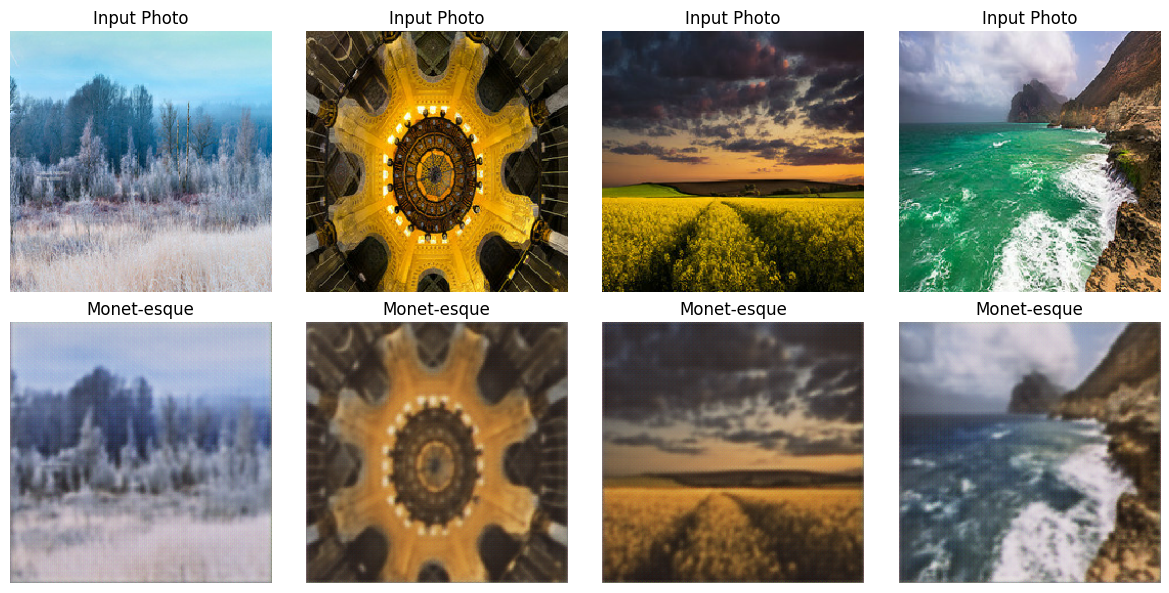

In [17]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i, img in enumerate(photo_ds.take(4)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[0, i].imshow(img)
    ax[1, i].imshow(prediction)
    ax[0, i].set_title("Input Photo")
    ax[1, i].set_title("Monet-esque")
    ax[0, i].axis("off")
    ax[1, i].axis("off")

plt.tight_layout()
plt.show()

In [18]:
print(history.history)

{'monet_disc_loss': [<tf.Tensor: shape=(1, 32, 32), dtype=float32, numpy=
array([[[0.59575224, 0.6124957 , 0.63523877, ..., 0.72570515,
         0.70945626, 0.6967086 ],
        [0.6361608 , 0.6531093 , 0.6852616 , ..., 0.77265227,
         0.73211014, 0.692802  ],
        [0.65146405, 0.6537553 , 0.6728061 , ..., 0.7416361 ,
         0.7115711 , 0.68537045],
        ...,
        [0.64897096, 0.6784114 , 0.64837146, ..., 0.7490662 ,
         0.7188438 , 0.6906378 ],
        [0.656032  , 0.6661538 , 0.65585715, ..., 0.7330834 ,
         0.7123157 , 0.6810755 ],
        [0.64959085, 0.65708876, 0.6475472 , ..., 0.6955446 ,
         0.6876929 , 0.6816673 ]]], dtype=float32)>], 'monet_gen_loss': [<tf.Tensor: shape=(1, 32, 32), dtype=float32, numpy=
array([[[4.523875 , 4.639613 , 4.7079854, ..., 4.475038 , 4.4548793,
         4.3131213],
        [4.844734 , 5.03425  , 5.103176 , ..., 4.8217006, 4.6756377,
         4.4429545],
        [4.792922 , 4.938847 , 5.007631 , ..., 4.744444 , 4.63132

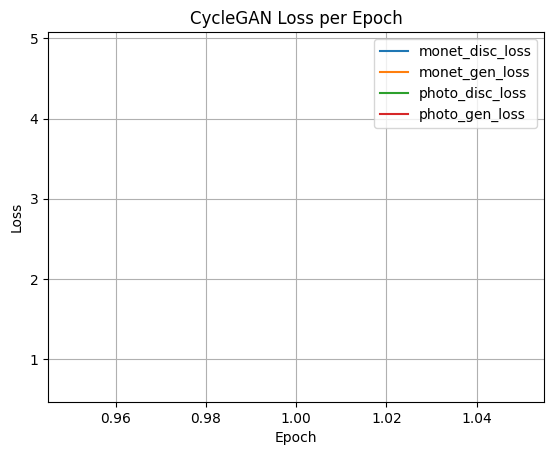

In [19]:
for name, losses in history.history.items():
    scalar_losses = [tf.reduce_mean(l).numpy() for l in losses]
    plt.plot(range(1, len(scalar_losses)+1), scalar_losses, label=name)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CycleGAN Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

## Submission
As recommended, I'll create an images directory and zip all generated images from the photo directory for submission. 

In [20]:
! mkdir ../images

In [21]:
for i, img in enumerate(tqdm(test_photo_ds, total=7028), 1):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")

7038it [08:01, 14.63it/s]


In [22]:
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

## References
- https://www.tensorflow.org/tutorials/generative/cyclegan
- https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/overview.ipynb#scrollTo=o-cuwvVbeb43
- https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook